# Downloading tiles from a WMTS

Author: Cor Zuurmond 

---

This notebook explains how to download tiles from a WMTS given a location (coordinate). 

We use the [aerial imagery WMTS](https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wmts?request=GetCapabilities&service=wmts) from PDOK. PDOK contains Dutch open data.

In [1]:
%matplotlib inline

In [2]:
import math
from io import BytesIO

import requests
from PIL import Image

In [3]:
# WMTS
wmts_base = 'https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wmts'
layer = 'Actueel_ortho25'

# Coordinate to request
amsterdam = 52.3522554, 4.9130319

In [4]:
def gps_to_tile(lat, lon, zoom):
    """
    Convert gps coordinate to tile number.
    
    Parameters
    ----------
    lat : float
        The latitude of the coordinate.
    lon : float
        The longitude of the coordinate.
    zoom : int
        Zoom level.
        
    Returns
    -------
    Tuple(float, float) : The tile (column, row) index.
    
    Source
    ------
    https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Tile_numbers_to_lon..2Flat._2
    """
    n = 2.0 ** zoom
    lat_rad = math.radians(lat)
    
    tile_col = int((lon + 180.0) / 360.0 * n)
    tile_row = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    
    return tile_col, tile_row


zoom = 12
tile_col, tile_row = gps_to_tile(*amsterdam, zoom=zoom)
tile_col, tile_row

(2103, 1346)

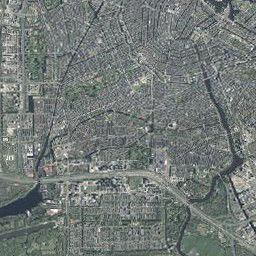

In [9]:
def get_wmts_tile_from_coordinate(coordinate, wmts_base, layer, zoom=0):
    """
    Gets an tile from the WMTS service given the coordinate.
    
    Parameters
    ----------
    coordinate : Tuple(float, float)
        The gps coordinate.
    wmts_base : str
        The base of th WMTS url.
    layer : str
        The layer to query in the WMTS service.
    zoom : int (default: 0)
        The zoom level
        
    Returns
    -------
    PIL.image : The tile (as PIL image).
    """
    tile_col, tile_row = gps_to_tile(*coordinate, zoom=zoom)
    
    params = (
        ('layer', layer),
        ('style', 'default'),
        ('tilematrixset', 'EPSG:3857'),
        ('Service', 'WMTS'),
        ('Request', 'GetTile'),
        ('Version', '1.0.0'),
        ('Format', 'image/png'),
        ('TileMatrix', '%02d' % zoom),
        ('TileCol', tile_col),
        ('TileRow', tile_row),
    )

    response = requests.get(wmts_base, params=params)

    # BytesIO is an in memory file
    image_bytes = BytesIO()
    image_bytes.write(response.content)
    image = Image.open(image_bytes)

    return image


get_wmts_tile_from_coordinate(amsterdam, wmts_base, layer, zoom=12)

In [8]:
# Create a gif that zooms in on Amsterdam
images = [get_wmts_tile_from_coordinate(amsterdam, wmts_base, layer, zoom=zoom) for zoom in range(6, 20)]
images[0].save(
    'static/zooming_amsterdam.gif', 
    format='GIF', 
    append_images=images[1:], 
    save_all=True, 
    duration=500, 
    loop=0
)

Note that the zoom is not similar as Google maps -  it does not feel "natural". On every zoom level the tile is requested that contains the coordinate. Becaus

<center>
    <img src="static/zooming_amsterdam.gif" width=30%>
</center>